In [1]:
pip install keras-facenet opencv-python numpy pillow tensorflow mtcnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
import cv2
import pickle
from PIL import Image as Img
from numpy import asarray, expand_dims
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN # <--- Import Library Baru

# ---------------------------------------------------------
# 1. PERSIAPAN (SETUP)
# ---------------------------------------------------------

# Inisialisasi Detektor MTCNN (Pengganti Haar Cascade)
detector = MTCNN()

# Load Model FaceNet
MyFaceNet = FaceNet()

print("✅ Model MTCNN dan FaceNet berhasil dimuat.")


✅ Model MTCNN dan FaceNet berhasil dimuat.


In [3]:
import os
import cv2
import numpy as np
import pickle
from PIL import Image as Img
from numpy import asarray, expand_dims
from keras_facenet import FaceNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn.mtcnn import MTCNN

# ==== SETUP MODEL & AUGMENTASI ====
MyFaceNet = FaceNet()
detector = MTCNN()

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# ==== TRAINING DATABASE (MTCNN + AUGMENTASI + RESUME) ====
base_folder = r'D:/Semester 5/Deep Learning/Dataset Sistem Presensi Wajah V2.0/Dataset Sistem Presensi Wajah V2.0' 
subfolders = ['Data Train', 'Data Test']
DB_FILE = "datafacenet_aug.pkl"
database = {}

print("⏳ Memulai proses database wajah...")

# 1. LOAD DATABASE LAMA (JIKA ADA)
if os.path.exists(DB_FILE):
    print(f"📂 Database ditemukan ({DB_FILE}). Memuat data lama...")
    with open(DB_FILE, "rb") as myfile:
        database = pickle.load(myfile)
    print(f"   ↳ {len(database)} data wajah sudah ada.")
else:
    print("📂 Database belum ada. Membuat baru.")
    database = {}

# 2. PROSES GAMBAR (HANYA YANG BELUM ADA)
for subfolder in subfolders:
    folder_path = os.path.join(base_folder, subfolder)
    if not os.path.exists(folder_path):
        print(f"⚠ Folder tidak ditemukan: {folder_path}")
        continue

    file_list = os.listdir(folder_path)
    print(f"\n📂 Memeriksa folder: {subfolder} ({len(file_list)} file)")

    count_new = 0
    for filename in file_list:
        file_path = os.path.join(folder_path, filename)
        if not os.path.isfile(file_path): continue

        # --- LOGIKA SKIP (PAUSE/RESUME) ---
        file_key = os.path.splitext(filename)[0]
        
        # Cek apakah file ini (key) sudah ada di database?
        # Kita cek key utamanya. Jika sudah ada, asumsinya augmentasinya juga sudah ada.
        if file_key in database:
            # Uncomment baris bawah jika ingin melihat log skip (bisa bikin penuh layar)
            # print(f"⏩ Skip: {filename} (Sudah ada)") 
            continue 

        # --- JIKA BELUM ADA, PROSES ---
        print(f"📸 Memproses data baru: {filename}...")
        try:
            gbr1 = cv2.imread(file_path)
            if gbr1 is None: continue
            
            gbr_rgb = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(gbr_rgb)
            
            if len(results) == 0:
                print(f"   ⚠ Wajah tidak terdeteksi: {filename}")
                continue 
            
            x1, y1, width, height = results[0]['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            
            gbr_pil = Img.fromarray(gbr_rgb)
            gbr_array = asarray(gbr_pil)
            face = gbr_array[y1:y2, x1:x2]
            face_pil = Img.fromarray(face).resize((160,160))
            face_array = asarray(face_pil)
            
            # 1. Simpan Wajah Asli
            face_input = expand_dims(face_array, axis=0)
            signature = MyFaceNet.embeddings(face_input)
            database[file_key] = signature

            # 2. Augmentasi
            i = 0
            for batch in datagen.flow(face_input, batch_size=1):
                aug_signature = MyFaceNet.embeddings(batch)
                aug_key = f"{file_key}_aug{i}"
                database[aug_key] = aug_signature
                i += 1
                if i >= 5: break 
            
            count_new += 1
            
            # Simpan Partial (Opsional: simpan setiap 10 data baru agar aman jika crash)
            if count_new % 10 == 0:
                with open(DB_FILE, "wb") as myfile:
                    pickle.dump(database, myfile)

        except Exception as e:
            print(f"❌ Error pada {filename}: {e}")

    print(f"   ✅ Selesai folder {subfolder}. Menambahkan {count_new} data baru.")

# 3. SIMPAN FINAL
if database:
    with open(DB_FILE, "wb") as myfile:
        pickle.dump(database, myfile)

print(f"\n🎉 SELESAI. Total Database: {len(database)} variasi wajah.")

⏳ Memulai proses database wajah...
📂 Database belum ada. Membuat baru.

📂 Memeriksa folder: Data Train (1296 file)
📸 Memproses data baru: 5221911012_Debora_01.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
📸 Memproses data baru: 5221911012_Debora_02.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
📸 Memproses data baru: 5221911012_Debora_03.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
📸 Memproses data baru: 5221911012_Debora_04.jpg...

In [4]:
# ---------------------------------------------------------
# 4. HITUNG AKURASI (DENGAN MTCNN)
# ---------------------------------------------------------
def extract_name(filename):
    clean_name = os.path.splitext(filename)[0]
    parts = clean_name.split('_')
    if len(parts) >= 2:
        return parts[1].lower()
    return "unknown"

def hitung_akurasi(folder_path, database, model, tipe_data="Dataset"):
    if not os.path.exists(folder_path):
        print(f"❌ Folder {tipe_data} tidak ditemukan.")
        return

    print(f"\n📊 Menghitung Akurasi {tipe_data} (menggunakan MTCNN)...")
    
    total = 0
    benar = 0
    file_list = os.listdir(folder_path)
    
    for i, filename in enumerate(file_list):
        file_path = os.path.join(folder_path, filename)
        if not os.path.isfile(file_path): continue
        
        # Progress bar
        if (i+1) % 10 == 0:
            print(f"   ... memproses {i+1}/{len(file_list)}")

        total += 1
        nama_asli = extract_name(filename)

        # 1. Baca Gambar
        img = cv2.imread(file_path)
        if img is None: continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Wajib RGB utk MTCNN
        
        # 2. Deteksi Wajah (GANTI HAAR -> MTCNN)
        results = detector.detect_faces(img_rgb)
        
        if len(results) == 0:
            continue # Skip jika wajah tidak ketemu
            
        # Ambil koordinat
        x1, y1, w, h = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + w, y1 + h
        
        try:
            # 3. Preprocessing (Crop -> Resize -> Embedding)
            img_pil = Img.fromarray(img_rgb)
            img_array = asarray(img_pil)
            
            face = img_array[y1:y2, x1:x2]
            face_pil = Img.fromarray(face).resize((160, 160))
            face_arr = asarray(face_pil)
            face_input = expand_dims(face_arr, axis=0)
            
            signature = model.embeddings(face_input)
            
            # 4. Bandingkan dengan Database
            min_dist = 100
            prediksi = "unknown"
            
            for key, value in database.items():
                dist = np.linalg.norm(value - signature)
                if dist < min_dist:
                    min_dist = dist
                    prediksi = key
            
            # Threshold (Sesuaikan, MTCNN biasanya lebih presisi jadi bisa diperketat)
            if min_dist > 0.8: 
                prediksi = "unknown"
                
            nama_prediksi = extract_name(prediksi)
            
            # 5. Cek Kebenaran
            if nama_prediksi == nama_asli:
                benar += 1
            
        except Exception as e:
            # print(f"Error: {e}") # Uncomment untuk debug
            pass

    # Hasil Akhir
    if total > 0:
        akurasi = (benar / total) * 100
        print(f"✅ Total: {total} | Benar: {benar} | Salah: {total - benar}")
        print(f"🎯 Akurasi {tipe_data}: {akurasi:.2f}%")

# ==== EKSEKUSI ====
train_folder = os.path.join(base_folder, 'Data Train')
test_folder = os.path.join(base_folder, 'Data Test')

hitung_akurasi(train_folder, database, MyFaceNet, "TRAINING")
hitung_akurasi(test_folder, database, MyFaceNet, "TESTING")


📊 Menghitung Akurasi TRAINING (menggunakan MTCNN)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
   ... memproses 10/1296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
   ... memproses 20/1296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━

⏳ Sedang memuat model FaceNet & HaarCascade...

📂 Memuat database wajah dari 'datafacenet_aug.pkl'...
✅ Database berhasil dimuat! Berisi 12942 data wajah.

📷 KAMERA AKTIF (Lihat jendela pop-up).
▶ Tekan [SPASI] : Ambil Foto
▶ Tekan [Q]     : Keluar
📸 Cekrek! Foto diambil.
⏳ Menganalisis wajah...
✅ Ditemukan 1 wajah.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


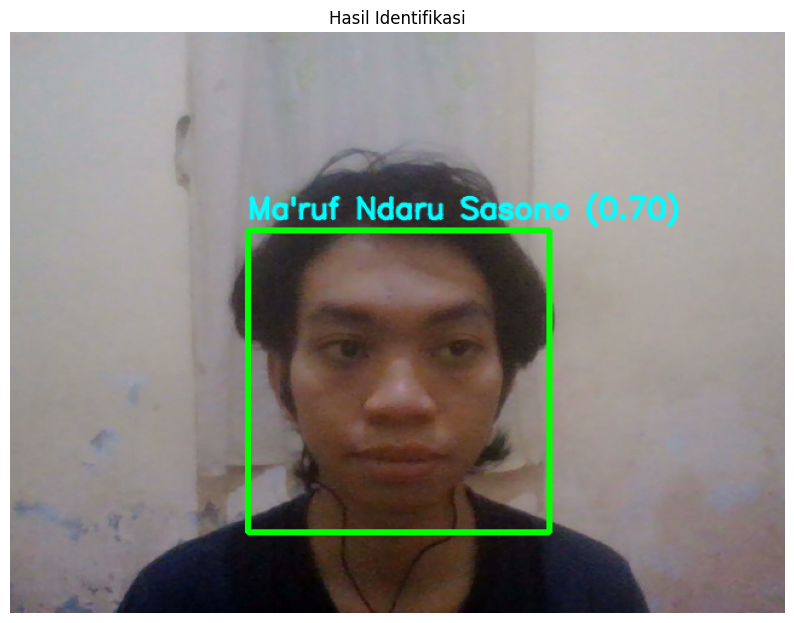

In [1]:
import os
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as Img
from numpy import asarray, expand_dims
from keras_facenet import FaceNet

# ==========================================
# 1. SETUP & LOAD (Agar Cell ini Mandiri)
# ==========================================

# A. Load Model Deteksi Wajah & Pengenalan
print("⏳ Sedang memuat model FaceNet & HaarCascade...")
haar_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
HaarCascade = cv2.CascadeClassifier(haar_path)
MyFaceNet = FaceNet()

# B. Load Database Wajah dari File (data.pkl)
# Ini kuncinya: Kita ambil data yang sudah ditraining sebelumnya
database = {}
if os.path.exists("datafacenet_aug.pkl"):
    print("📂 Memuat database wajah dari 'datafacenet_aug.pkl'...")
    with open("datafacenet_aug.pkl", "rb") as myfile:
        database = pickle.load(myfile)
    print(f"✅ Database berhasil dimuat! Berisi {len(database)} data wajah.")
else:
    print("❌ WARNING: File 'datafacenet_aug.pkl' tidak ditemukan!")
    print("   Silakan jalankan Cell 2 (Training) terlebih dahulu untuk membuat database.")

# ==========================================
# 2. FUNGSI PEMROSESAN GAMBAR
# ==========================================

def process_and_display(img_bgr, database, model):
    if img_bgr is None:
        print("❌ Tidak ada gambar untuk diproses.")
        return

    # Buat salinan untuk digambar
    img_result = img_bgr.copy()
    
    # Konversi ke RGB untuk pemrosesan FaceNet dan Matplotlib
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_array = asarray(Img.fromarray(img_rgb))

    # Deteksi wajah
    wajah = HaarCascade.detectMultiScale(img_bgr, 1.1, 4)
    
    if len(wajah) == 0:
        print("⚠️ Wajah tidak terdeteksi dalam foto.")
    else:
        print(f"✅ Ditemukan {len(wajah)} wajah.")

    for (x1, y1, w, h) in wajah:
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + w, y1 + h
        
        try:
            # Crop dan Preprocess
            face = img_array[y1:y2, x1:x2]
            face_pil = Img.fromarray(face)
            face_pil = face_pil.resize((160, 160))
            face_arr = asarray(face_pil)
            face_arr = expand_dims(face_arr, axis=0)
            
            # Embedding & Matching
            signature = model.embeddings(face_arr)
            min_dist = 100
            identity = 'Unknown'
            
            # Bandingkan dengan database yang sudah di-load
            for key, value in database.items():
                dist = np.linalg.norm(value - signature)
                if dist < min_dist:
                    min_dist = dist
                    identity = key

            # Threshold (Batas toleransi kemiripan)
            if min_dist > 0.8: 
                identity = "Unknown"
            
            # Formatting Nama (Menghapus ID atau suffix _aug jika ada)
            display_name = identity
            if '_' in identity:
                # Asumsi format: ID_Nama_No atau Nama_aug0
                parts = identity.split('_')
                # Logika sederhana: ambil bagian teks terpanjang atau bagian kedua
                if len(parts) >= 2:
                     display_name = parts[1] 

            label = f"{display_name} ({min_dist:.2f})"
            
            # Gambar Kotak (Hijau = Kenal, Merah = Unknown)
            box_color = (0, 255, 0) if identity != "Unknown" else (255, 0, 0) # RGB untuk Matplotlib nanti
            
            # Di OpenCV gambar rectangle pakai BGR, tapi karena kita convert di akhir,
            # kita pakai logika warna RGB di sini agar sesuai saat plt.imshow
            
            # Gambar di img_result (masih BGR) -> Merah is (0,0,255), Hijau (0,255,0)
            cv_color = (0, 255, 0) if identity != "Unknown" else (0, 0, 255)
            
            cv2.rectangle(img_result, (x1, y1), (x2, y2), cv_color, 3)
            cv2.putText(img_result, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, (255, 255, 0), 2, cv2.LINE_AA)
            
        except Exception as e:
            print(f"Error processing face: {e}")

    # --- TAMPILKAN HASIL DI JUPYTER ---
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Hasil Identifikasi")
    plt.show()

# ==========================================
# 3. LOOP KAMERA (SNAPSHOT)
# ==========================================

def take_snapshot_and_detect():
    # Cek apakah database kosong
    if not database:
        print("⛔ Database kosong! Harap jalankan training (Cell 2) dulu atau pastikan 'data.pkl' ada.")
        return

    cap = cv2.VideoCapture(0) 
    
    if not cap.isOpened():
        print("❌ Kamera tidak terdeteksi!")
        return

    print("\n📷 KAMERA AKTIF (Lihat jendela pop-up).")
    print("▶ Tekan [SPASI] : Ambil Foto")
    print("▶ Tekan [Q]     : Keluar")

    captured_frame = None

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Gagal membaca frame.")
                break

            cv2.imshow('Sistem Presensi - Tekan SPASI', frame)
            
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord(' '): # Spasi
                captured_frame = frame
                print("📸 Cekrek! Foto diambil.")
                break
            elif key == ord('q'):
                print("Batal.")
                break

    finally:
        cap.release()
        cv2.destroyAllWindows()
        for i in range(5): cv2.waitKey(1) # Memastikan window tertutup

    # Proses jika ada gambar
    if captured_frame is not None:
        print("⏳ Menganalisis wajah...")
        time.sleep(0.5)
        process_and_display(captured_frame, database, MyFaceNet)

# Jalankan
take_snapshot_and_detect()